# SciPy MILP Optimizer for Qiskit Optimization

Takashi Imamichi (imamichi@jp.ibm.com)

Qiskit Demodays

June 1, 2023

# Background

Qiskit optimization contains classical solvers such as CPLEX and Gurobi as well as quantum solvers such as QAOA.

But CPLEX and Gurobi are commercial software and the libraries installed via pip have some limitations such as number of variables and number of constraints. Moreover, pip version of CPLEX for Apple Silicon is not available yet.

In [1]:
# pip version of CPLEX is not available for Apple silicon
%pip install cplex

ERROR: Could not find a version that satisfies the requirement cplex (from versions: none)
ERROR: No matching distribution found for cplex
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import GurobiOptimizer

In [3]:
prob = QuadraticProgram()
n = 2001
prob.binary_var_list(n)
prob.minimize(linear=np.ones(n))
print(prob.prettyprint())

Problem name: 

Minimize
  x0 + x1 + x10 + x100 + x1000 + x1001 + x1002 + x1003 + x1004 + x1005 + x1006
  + x1007 + x1008 + x1009 + x101 + x1010 + x1011 + x1012 + x1013 + x1014 + x1015
  + x1016 + x1017 + x1018 + x1019 + x102 + x1020 + x1021 + x1022 + x1023 + x1024
  + x1025 + x1026 + x1027 + x1028 + x1029 + x103 + x1030 + x1031 + x1032 + x1033
  + x1034 + x1035 + x1036 + x1037 + x1038 + x1039 + x104 + x1040 + x1041 + x1042
  + x1043 + x1044 + x1045 + x1046 + x1047 + x1048 + x1049 + x105 + x1050 + x1051
  + x1052 + x1053 + x1054 + x1055 + x1056 + x1057 + x1058 + x1059 + x106 + x1060
  + x1061 + x1062 + x1063 + x1064 + x1065 + x1066 + x1067 + x1068 + x1069 + x107
  + x1070 + x1071 + x1072 + x1073 + x1074 + x1075 + x1076 + x1077 + x1078
  + x1079 + x108 + x1080 + x1081 + x1082 + x1083 + x1084 + x1085 + x1086 + x1087
  + x1088 + x1089 + x109 + x1090 + x1091 + x1092 + x1093 + x1094 + x1095 + x1096
  + x1097 + x1098 + x1099 + x11 + x110 + x1100 + x1101 + x1102 + x1103 + x1104
  + x1105 + x1

In [4]:
GurobiOptimizer().solve(prob)

Restricted license - for non-production use only - expires 2024-10-28


QiskitOptimizationError: 'Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license'

## SciPy MILP solver

SciPy 1.9.0 (released on July 29, 2022) introduced a mixed integer linear programming (MILP) solver based on the HiGHS linear optimization software.

References:
- https://github.com/scipy/scipy/releases/tag/v1.9.0
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.milp.html
- https://docs.scipy.org/doc/scipy/release.1.9.0.html#highlights-of-this-release
- https://highs.dev/

## QAMP 2022 Fall Project

I proposed to implement an optimizer `ScipyMilpOptimizer` for Qiskit optimization based on the SciPy MILP solver. Yunzhe worked on the project and completed the base implementation. Then, I took over the PR and completed the tests and documentation. This PR has been merged and the upcoming version 0.6.0 of Qiskit optimization will include this feature.


References
- https://github.com/qiskit-advocate/qamp-fall-22/issues/2
- https://github.com/Qiskit/qiskit-optimization/pull/496

## `ScipyMilpOptimizer`

`ScipyMilpOptimizer` is the new classical optimizer for Qiskit optimization.

Pros
- No limitation of number of variables and number of constraints
- Supports continuous variables as well as binary and integer variables
  - Note: standard QAOA cannot handle contiuous variables

Cons
- Supports only linear terms (quadratic terms are not allows, e.g., QUBO)
- Performance is inferior to commercial solvers (Gurobi, CPLEX)

## Use case: Knapsack problem

You have a knapsack with a capacity and items to pack. Each item has a value and weight. You want to maximize the sum of values so that the total weight is within the capacity.

In [5]:
from qiskit_optimization.applications import Knapsack

prob = Knapsack(
    values = [1, 2, 3, 4],
    weights= [5, 6, 7, 8],
    max_weight=20
).to_quadratic_program()

print(prob.prettyprint())

Problem name: Knapsack

Maximize
  x_0 + 2*x_1 + 3*x_2 + 4*x_3

Subject to
  Linear constraints (1)
    5*x_0 + 6*x_1 + 7*x_2 + 8*x_3 <= 20  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



You can solve this problem directly with `ScipyMilpOptimizer`.

In [6]:
from qiskit_optimization.algorithms import ScipyMilpOptimizer

milp = ScipyMilpOptimizer()
result = milp.solve(prob)
print(result)

fval=8.0, x_0=1, x_1=0, x_2=1, x_3=1, status=SUCCESS


## Use case: Maxcut

You want to split graph nodes into two groups and maximize the number of edges spanning them.

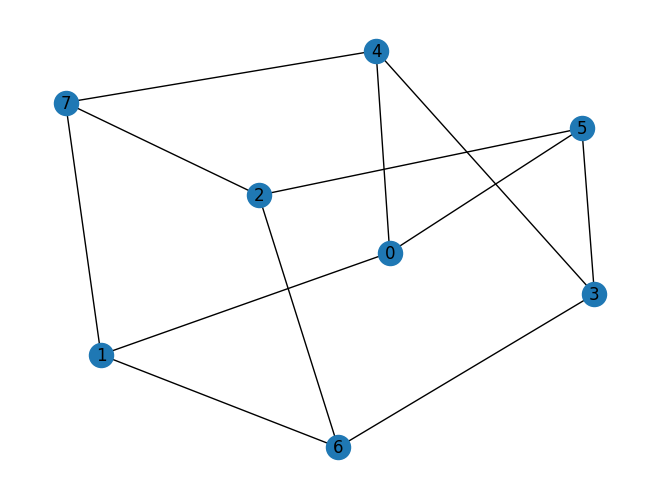

In [7]:
from qiskit_optimization.applications import Maxcut
import networkx as nx

graph = nx.random_regular_graph(d=3, n=8, seed=123)
maxcut = Maxcut(graph)
pos = nx.spring_layout(graph, seed=123)
maxcut.draw(pos=pos)

In [8]:
prob = maxcut.to_quadratic_program()
print(prob.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_1*x_6 - 2*x_1*x_7 - 2*x_2*x_5
  - 2*x_2*x_6 - 2*x_2*x_7 - 2*x_3*x_4 - 2*x_3*x_5 - 2*x_3*x_6 - 2*x_4*x_7
  + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4 + 3*x_5 + 3*x_6 + 3*x_7

Subject to
  No constraints

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7



`ScipyMilpOptimizer` cannot solve it directly due to quadratic terms.

In [9]:
result = milp.solve(prob)

QiskitOptimizationError: 'Incompatible problem: scipy.milp supports only linear objective function'

## Convert quadratic terms into linear terms

There is a well-known technique to linearize quadratic terms of binary variables as follows (aka McCormick linearization).
Assume that $x$ and $y$ are binary variables and $z = x \cdot y$.

$$
\begin{align}
z &\leq x,\\
z &\leq y,\\
z &\geq x + y - 1,\\
z &\in [0, 1].
\end{align}
$$

In [10]:
def quadratic_to_linear(problem: QuadraticProgram) -> QuadraticProgram:
    new_prob = QuadraticProgram(problem.name)
    for x in problem.variables:
        new_prob._add_variable(x.lowerbound, x.upperbound, x.vartype, x.name)
    obj = problem.objective
    lin = obj.linear.to_dict(use_name=True)
    quad = obj.quadratic.to_dict(use_name=True)
    prod = {}
    for (x, y), coeff in quad.items():
        name = f"{x}_AND_{y}"
        prod[x, y] = name
        new_prob.continuous_var(0, 1, name)
        lin[name] = coeff
    for (x, y), name in prod.items():
        new_prob.linear_constraint({name: 1, x: -1}, "<=", 0)
        new_prob.linear_constraint({name: 1, y: -1}, "<=", 0)
        new_prob.linear_constraint({name: 1, x: -1, y: -1}, ">=", -1)
    if obj.sense == obj.sense.MAXIMIZE:
        new_prob.maximize(obj.constant, lin)
    else:
        new_prob.minimize(obj.constant, lin)
    return new_prob

Let's convert the maxcut problem instance into a new problem w/o quadratic terms.

In [11]:
new_prob = quadratic_to_linear(prob)
print(new_prob.prettyprint())

Problem name: Max-cut

Maximize
  3*x_0 - 2*x_0_AND_x_1 - 2*x_0_AND_x_4 - 2*x_0_AND_x_5 + 3*x_1 - 2*x_1_AND_x_6
  - 2*x_1_AND_x_7 + 3*x_2 - 2*x_2_AND_x_5 - 2*x_2_AND_x_6 - 2*x_2_AND_x_7
  + 3*x_3 - 2*x_3_AND_x_4 - 2*x_3_AND_x_5 - 2*x_3_AND_x_6 + 3*x_4
  - 2*x_4_AND_x_7 + 3*x_5 + 3*x_6 + 3*x_7

Subject to
  Linear constraints (36)
    -x_0 + x_0_AND_x_1 <= 0  'c0'
    x_0_AND_x_1 - x_1 <= 0  'c1'
    -x_0 + x_0_AND_x_1 - x_1 >= -1  'c2'
    -x_0 + x_0_AND_x_4 <= 0  'c3'
    x_0_AND_x_4 - x_4 <= 0  'c4'
    -x_0 + x_0_AND_x_4 - x_4 >= -1  'c5'
    -x_3 + x_3_AND_x_4 <= 0  'c6'
    x_3_AND_x_4 - x_4 <= 0  'c7'
    -x_3 + x_3_AND_x_4 - x_4 >= -1  'c8'
    -x_0 + x_0_AND_x_5 <= 0  'c9'
    x_0_AND_x_5 - x_5 <= 0  'c10'
    -x_0 + x_0_AND_x_5 - x_5 >= -1  'c11'
    -x_2 + x_2_AND_x_5 <= 0  'c12'
    x_2_AND_x_5 - x_5 <= 0  'c13'
    -x_2 + x_2_AND_x_5 - x_5 >= -1  'c14'
    -x_3 + x_3_AND_x_5 <= 0  'c15'
    x_3_AND_x_5 - x_5 <= 0  'c16'
    -x_3 + x_3_AND_x_5 - x_5 >= -1  'c17'
    -x_1 + x

`ScipyMilpOptimizer` can solve the new problem.

In [12]:
result = milp.solve(new_prob)
print(result)

fval=10.0, x_0=1.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=0.0, x_0_AND_x_1=0.9999999999999999, x_0_AND_x_4=0.0, x_3_AND_x_4=0.0, x_0_AND_x_5=0.0, x_2_AND_x_5=0.0, x_3_AND_x_5=0.0, x_1_AND_x_6=0.0, x_2_AND_x_6=0.0, x_3_AND_x_6=0.0, x_1_AND_x_7=0.0, x_2_AND_x_7=0.0, x_4_AND_x_7=0.0, status=SUCCESS


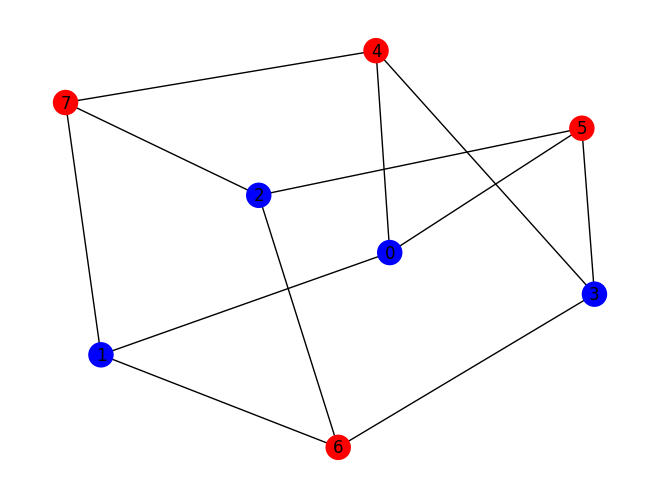

In [13]:
maxcut.draw(result.x[:prob.get_num_vars()], pos)

Let's compare the result with that by Gurobi. The objective function value (`fval`) is same.

In [14]:
result = GurobiOptimizer().solve(prob)
print(result)

fval=10.0, x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, status=SUCCESS


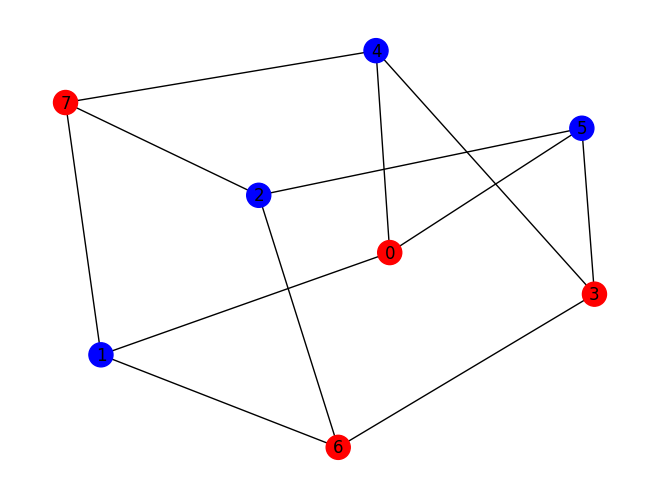

In [15]:
maxcut.draw(result, pos)